# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torch import optim
from torchsummary import summary

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
np.random.seed(1789)

batch_size = 64
val_dataset_pct = 0.2

data_dir = 'data/landmark_images/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

show_transforms = transforms.Compose([
    transforms.Resize(255), 
    transforms.RandomCrop(224),
    transforms.ToTensor()
    ])

train_data_transforms = transforms.Compose([
    transforms.Resize(255), 
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
    ])

test_data_transforms = transforms.Compose([
    transforms.Resize(255), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
    ])
show_data = datasets.ImageFolder(train_dir, transform=show_transforms)
train_data = datasets.ImageFolder(train_dir, 
                                  transform=train_data_transforms)
test_data = datasets.ImageFolder(test_dir, 
                                 transform=test_data_transforms)
print(f"Number of train instances = {len(train_data)}")
print(f"Number of test instances = {len(test_data)}")

indices = np.arange(0, len(train_data), 1, dtype=int)
np.random.shuffle(indices)
split = int(np.floor(val_dataset_pct*len(indices)))
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    sampler = train_sampler
    )
show_loader = DataLoader(
    dataset = show_data,
    batch_size = batch_size,
    sampler = train_sampler
    )
val_loader = DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    sampler = val_sampler
    )
test_loader = DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True
    )

loaders_scratch = {'train': train_loader, 'valid': val_loader, 
                   'test': test_loader}

Number of train instances = 4996
Number of test instances = 1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

1. First it resizes the images to $3\times 255\times 255$ pixels, to avoid losing to much information. Then, for the training `data_loader`, it makes a random crop of the resized image of $3\times 224\times 224$. This randomness is added as a regularization term to avoid overfitting the model rapidly. For the test data I just take a center crop of the resized image. 

2. I just used random cropping to add some augmentation to the training data. I didn't used additional augmentation because, for the objective of the exercise, I got good enough results. If I had to improve further, I would increase the number of epochs for training the model, and include some low degree rotations and flips.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

*Check for data imbalances between the different classes*:

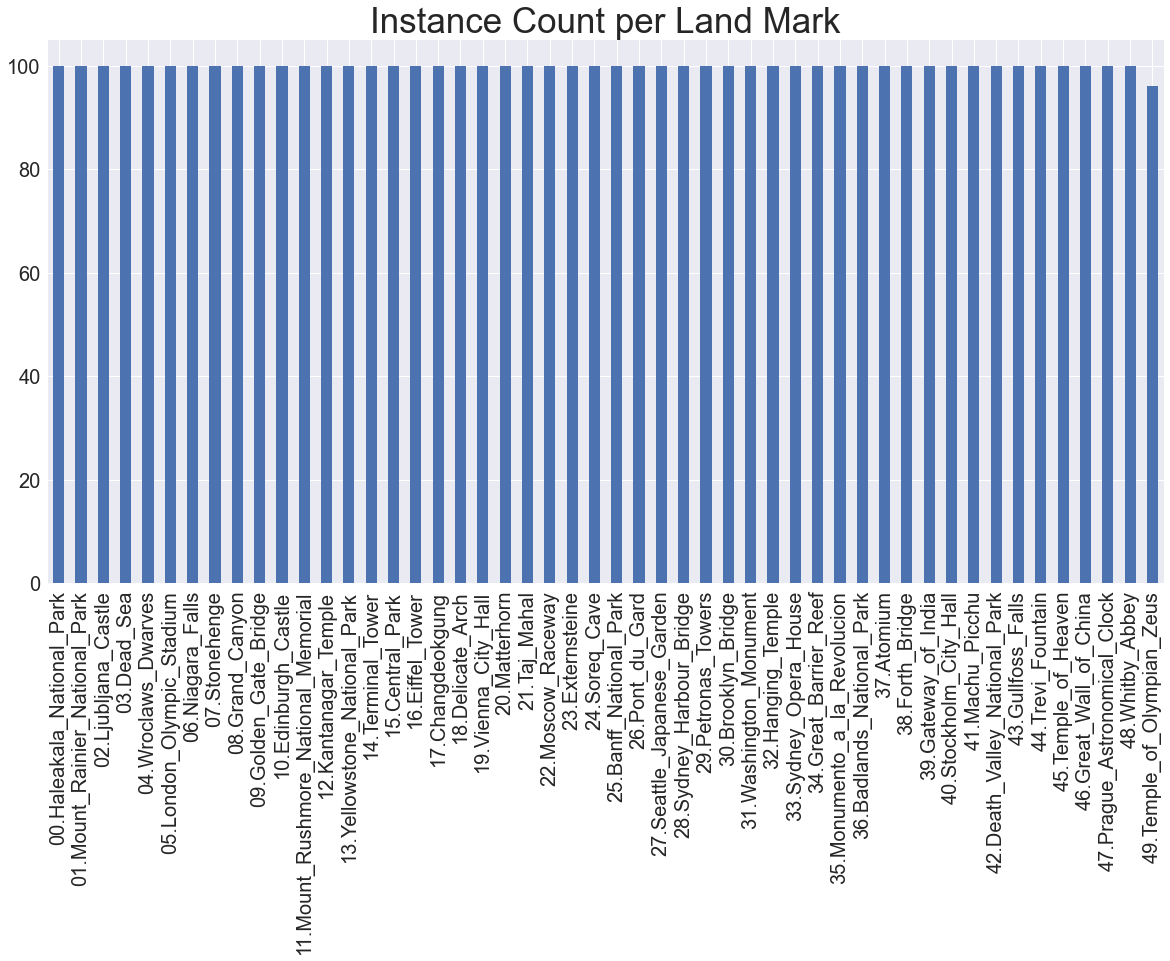

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mlp
import pandas as pd
mlp.style.use('seaborn')
%matplotlib inline

data_dir = os.listdir('data/landmark_images/train')
instance_counter = dict()
for land_mark in data_dir:
    temp_dir = 'data/landmark_images/train/'+land_mark
    instances = len(os.listdir(temp_dir))
    instance_counter[land_mark] = instances
df = pd.DataFrame(data=list(instance_counter.values()), 
                  index=list(instance_counter.keys()))
df.plot(kind='bar', figsize=(20,10), fontsize=20, legend=False)
plt.title("Instance Count per Land Mark", fontsize=35);

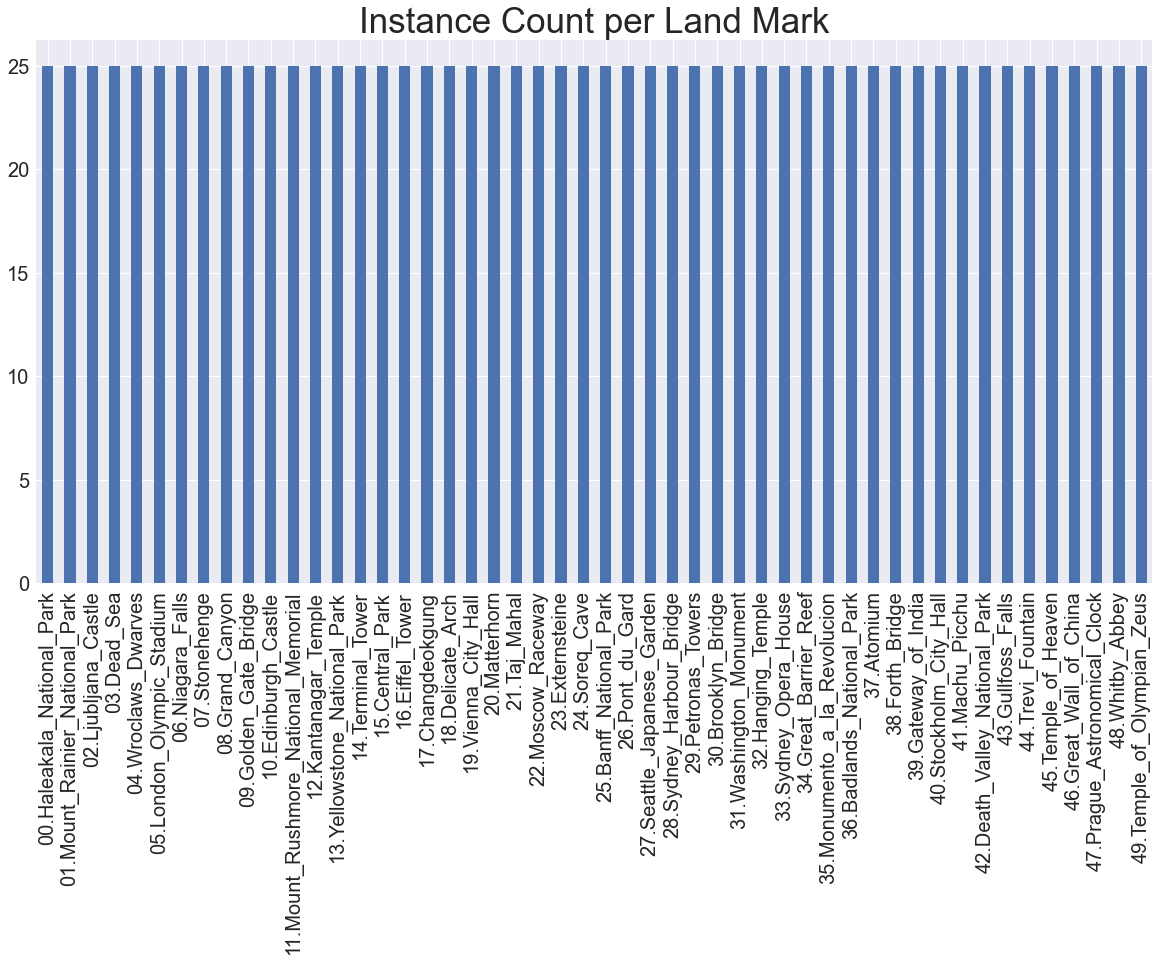

In [5]:
data_dir = os.listdir('data/landmark_images/test')
instance_counter = dict()
for land_mark in data_dir:
    temp_dir = 'data/landmark_images/test/'+land_mark
    instances = len(os.listdir(temp_dir))
    instance_counter[land_mark] = instances
df = pd.DataFrame(data=list(instance_counter.values()), 
                  index=list(instance_counter.keys()))
df.plot(kind='bar', figsize=(20,10), fontsize=20, legend=False)
plt.title("Instance Count per Land Mark", fontsize=35);

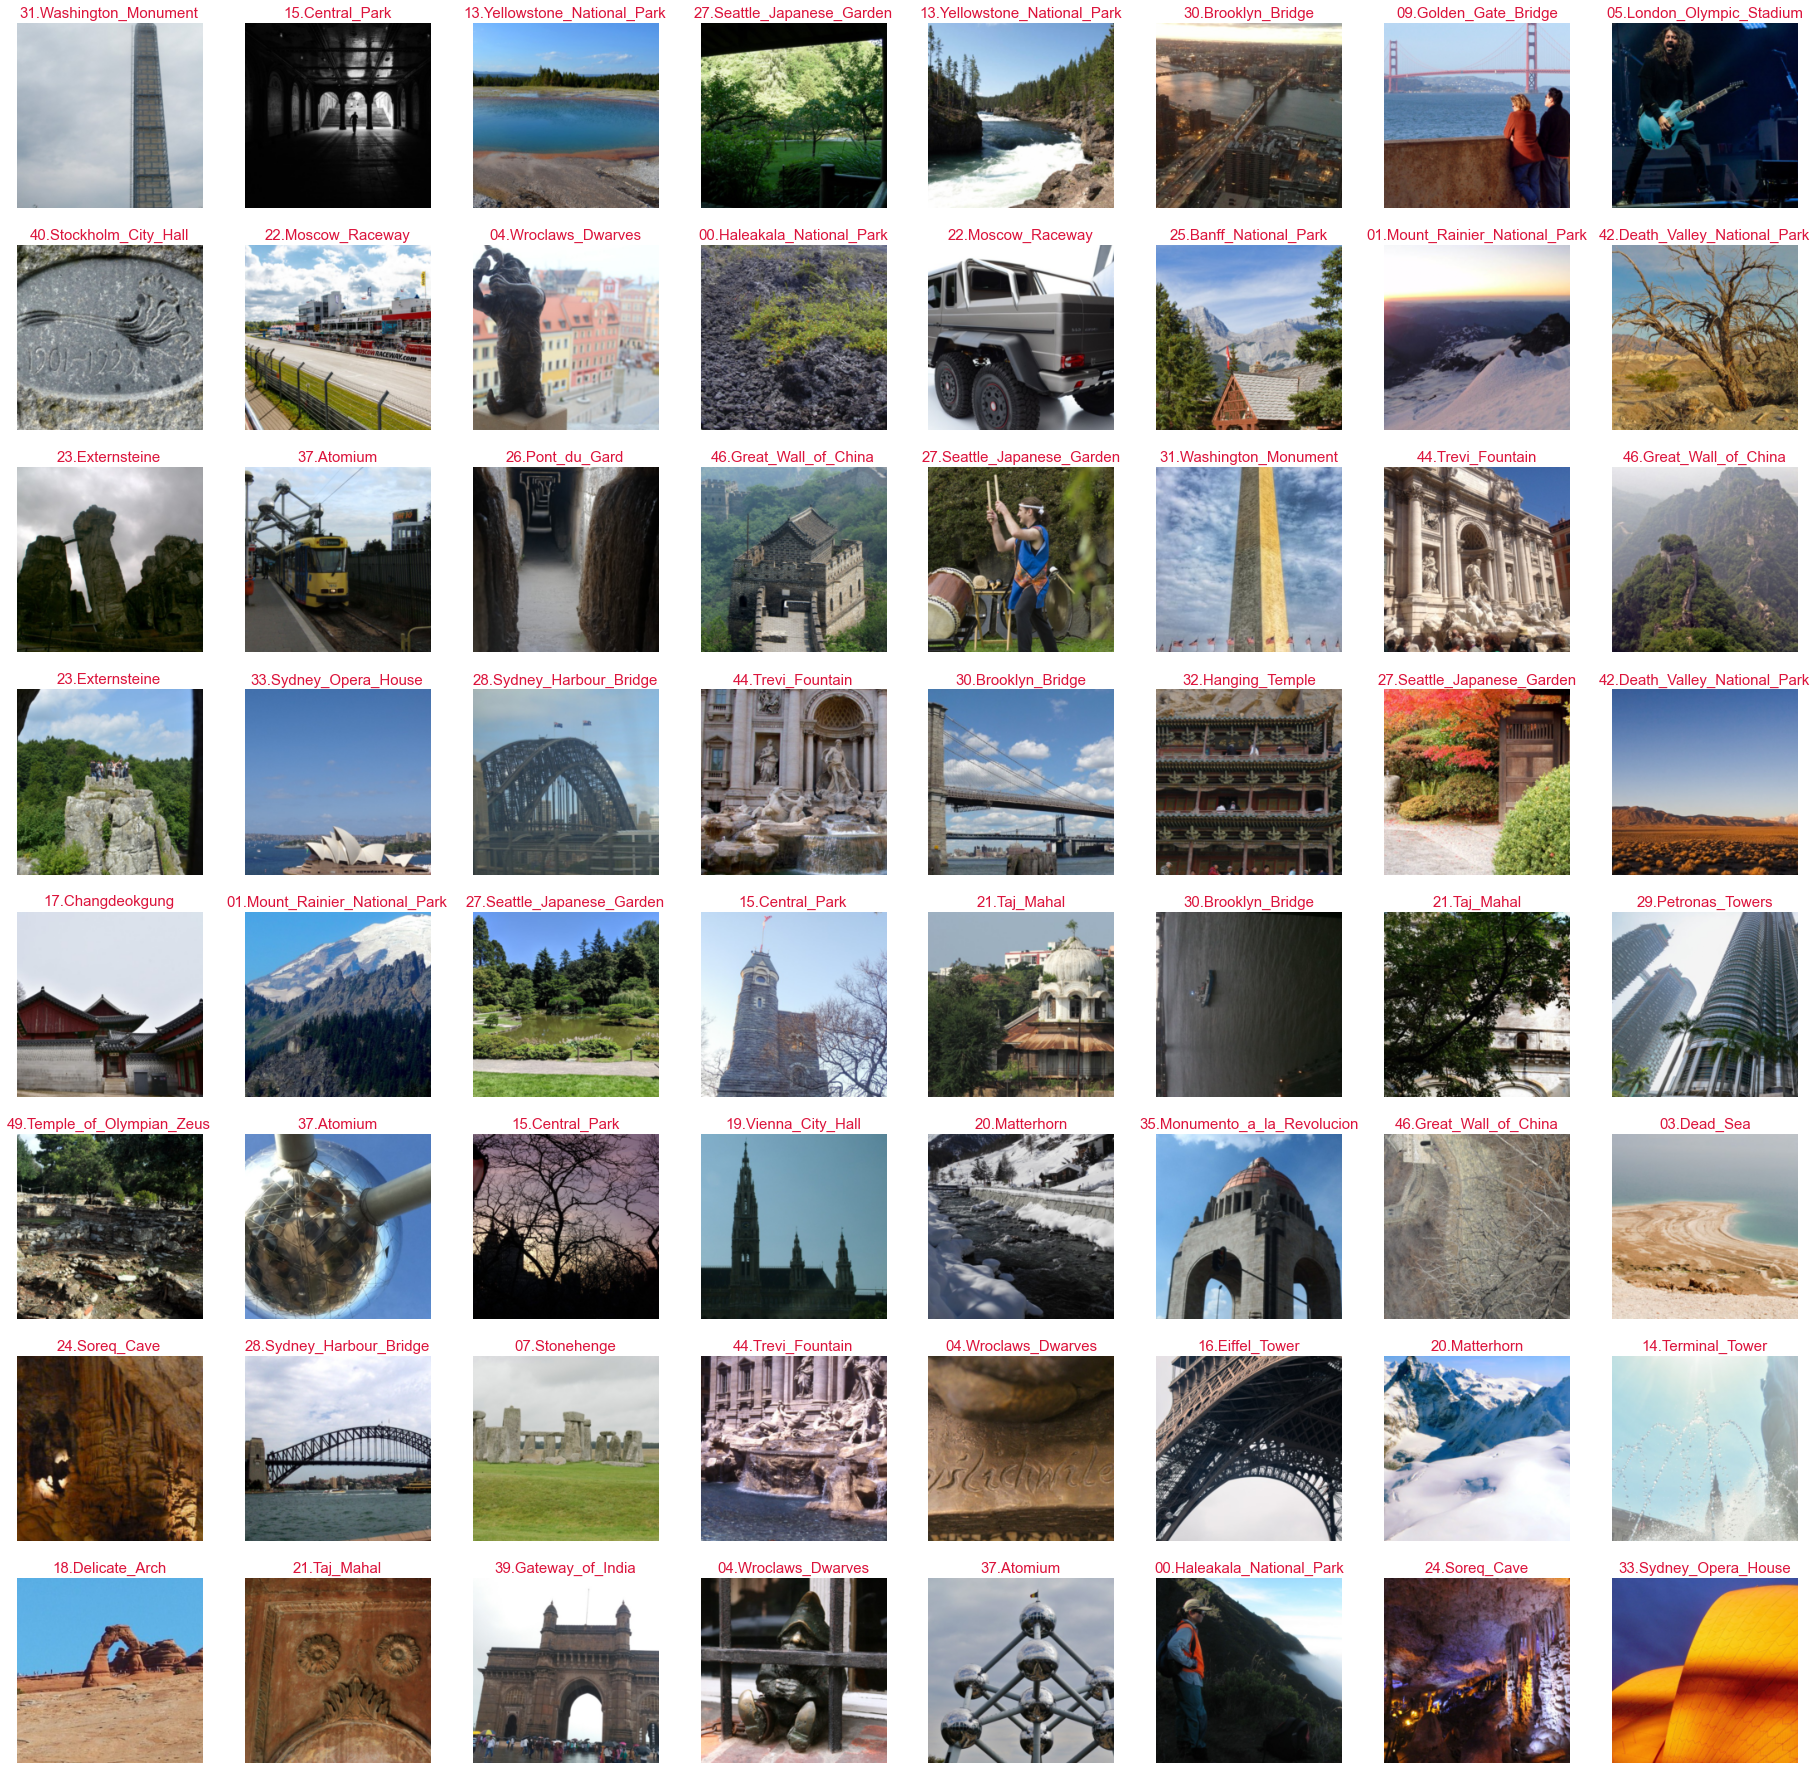

In [17]:
## TODO: visualize a batch of the train data loader
dataiter = iter(show_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(32, 32))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_data.classes[labels[idx]], fontsize=15, color='crimson')
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


### Initialize use_cuda variable

In [7]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [8]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.Adam(model.parameters())
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [9]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super().__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3,padding=1)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*7*7, 1024)
        self.fc2 = nn.Linear(1024, 50)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.batchnorm4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = self.pool(x)
        x = x.view(-1, 256*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [10]:
summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
       BatchNorm2d-5         [-1, 32, 112, 112]              64
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
       BatchNorm2d-8           [-1, 64, 56, 56]             128
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
      BatchNorm2d-11          [-1, 128, 28, 28]             256
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Conv2d-13          [-1, 256, 14, 14]         295,168
      BatchNorm2d-14          [-1, 256,

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  First I tested a relatively simple CNN architecture to see how it behaved. I found that I needed to compress more the intermediate images to decrease the number of parameters when it goes to the fully connected layers, and regularization to mitigate the overfitting. Then I researched good initialization methods for CNNs with a ReLU activation function, and found that the He normal (in PyTorch, `kaiming_normal`) initialization for ReLU (and related activations) works well. Finally, to help the CNN to avoid overfitting (due the the relatively small dataset), I used batch normalization, which  also helps with the vanishing/exploding gradient problem.

To find the final architecture I had to downsize my original model, because the RAM of my GPU (and the workspace's GPU) doesn't have enough resources to train it. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [11]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            output = model(data)
            loss = criterion(output, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.shape[0]
            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.shape[0]
        
        train_loss /= len(loaders['train'].dataset)
        valid_loss /= len(loaders['valid'].dataset)
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss<valid_loss_min:
            print('Validation loss decreased {:4.6f}%. Saving Model'.format(
                    (valid_loss/valid_loss_min-1)*100)
                 )
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [13]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', 
                                nonlinearity='relu')
        nn.init.constant_(m.bias, 0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, 
                      get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'conv5bn_kaiming_normal.pt')

Epoch: 1 	Training Loss: 6.979479 	Validation Loss: 0.757796
Validation loss decreased -100.000000%. Saving Model
Epoch: 2 	Training Loss: 2.847090 	Validation Loss: 0.719017
Validation loss decreased -5.117237%. Saving Model
Epoch: 3 	Training Loss: 2.675739 	Validation Loss: 0.684993
Validation loss decreased -4.732033%. Saving Model
Epoch: 4 	Training Loss: 2.547547 	Validation Loss: 0.664272
Validation loss decreased -3.025085%. Saving Model
Epoch: 5 	Training Loss: 2.429894 	Validation Loss: 0.658343
Validation loss decreased -0.892539%. Saving Model
Epoch: 6 	Training Loss: 2.315103 	Validation Loss: 0.648446
Validation loss decreased -1.503268%. Saving Model
Epoch: 7 	Training Loss: 2.215072 	Validation Loss: 0.636990
Validation loss decreased -1.766722%. Saving Model
Epoch: 8 	Training Loss: 2.119557 	Validation Loss: 0.637671
Epoch: 9 	Training Loss: 2.011413 	Validation Loss: 0.611916
Validation loss decreased -3.936313%. Saving Model
Epoch: 10 	Training Loss: 1.935533 	Valid

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [15]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.052763 	Validation Loss: 0.752788
Validation loss decreased -100.000000%. Saving Model
Epoch: 2 	Training Loss: 2.847409 	Validation Loss: 0.714478
Validation loss decreased -5.089110%. Saving Model
Epoch: 3 	Training Loss: 2.696847 	Validation Loss: 0.689714
Validation loss decreased -3.466123%. Saving Model
Epoch: 4 	Training Loss: 2.576299 	Validation Loss: 0.670105
Validation loss decreased -2.843053%. Saving Model
Epoch: 5 	Training Loss: 2.462161 	Validation Loss: 0.653097
Validation loss decreased -2.538100%. Saving Model
Epoch: 6 	Training Loss: 2.357694 	Validation Loss: 0.649980
Validation loss decreased -0.477175%. Saving Model
Epoch: 7 	Training Loss: 2.287427 	Validation Loss: 0.627308
Validation loss decreased -3.488187%. Saving Model
Epoch: 8 	Training Loss: 2.198951 	Validation Loss: 0.629583
Epoch: 9 	Training Loss: 2.104956 	Validation Loss: 0.621759
Validation loss decreased -0.884587%. Saving Model
Epoch: 10 	Training Loss: 2.027745 	Valid

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('conv5bn_kaiming_normal.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.755027


Test Accuracy: 53% (2670/4996)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [19]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, 'valid': val_loader, 
                    'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [20]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.Adam(model.parameters())
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [36]:
## TODO: Specify model architecture
model_transfer = models.densenet121(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
model_transfer.classifier = nn.Linear(1024, 50)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I chose the ResNet architecture to use as the basis for transfer learning. I chose it because it performs very well on ImageNet, and because its innovative architecture can also go very deep, allowing it to find more high-level features, avoiding the vanishing gradient problem. I think this is key, specially for the difficult training set given for this exercise. Furthermore, due to its constant use of batch normalization, I expect that it doesn't overfits the training data. 

Finally, I replaced the last layer of the model (`classifier`) with my own `nn.Linear()` layer so that it outputs the correct number of classes for the task at hand (50). 

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [39]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
optimizer = optim.Adam(model_transfer.classifier.parameters())
train(25, loaders_transfer, model_transfer, optimizer, criterion_transfer,
      use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.402058 	Validation Loss: 0.436705
Validation loss decreased -100.000000%. Saving Model
Epoch: 2 	Training Loss: 1.423149 	Validation Loss: 0.325052
Validation loss decreased -25.567193%. Saving Model
Epoch: 3 	Training Loss: 1.085250 	Validation Loss: 0.281148
Validation loss decreased -13.506683%. Saving Model
Epoch: 4 	Training Loss: 0.915969 	Validation Loss: 0.253413
Validation loss decreased -9.864992%. Saving Model
Epoch: 5 	Training Loss: 0.805437 	Validation Loss: 0.239941
Validation loss decreased -5.316029%. Saving Model
Epoch: 6 	Training Loss: 0.726220 	Validation Loss: 0.222398
Validation loss decreased -7.311407%. Saving Model
Epoch: 7 	Training Loss: 0.669197 	Validation Loss: 0.222229
Validation loss decreased -0.076147%. Saving Model
Epoch: 8 	Training Loss: 0.612590 	Validation Loss: 0.216101
Validation loss decreased -2.757362%. Saving Model
Epoch: 9 	Training Loss: 0.581386 	Validation Loss: 0.207202
Validation loss decreased -4.117944%. S

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [40]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.460361


Test Accuracy: 89% (4457/4996)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [60]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    # Process the image:
    image = Image.open(img_path).convert('RGB')
    in_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    
    t_image = in_transforms(image)[:3, :, :].unsqueeze(0).to(device=device)
    
    # Predict landmark:
    model_transfer.eval()
    output = model_transfer(t_image)
    _, top_classes = output.topk(k, dim=1)
    top_classes = np.squeeze(top_classes.to(device='cpu').numpy())
    top_classes = [train_data.classes[i] for i in top_classes]
    
    return top_classes


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['09.Golden_Gate_Bridge',
 '30.Brooklyn_Bridge',
 '38.Forth_Bridge',
 '28.Sydney_Harbour_Bridge',
 '33.Sydney_Opera_House']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [63]:
def predict_landmarks(img_path, k):
    # Process the image:
    image = Image.open(img_path).convert('RGB')
    in_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    
    t_image = in_transforms(image)[:3, :, :].unsqueeze(0).to(device=device)
    
    # Predict landmark:
    with torch.no_grad():
        output = torch.softmax(model_transfer(t_image), dim=1)
        probs, top_classes = output.topk(k, dim=1)
        top_classes = np.squeeze(top_classes.to(device='cpu').numpy())
        probs =  np.squeeze(probs.to(device='cpu').numpy())
        top_classes = [train_data.classes[i] for i in top_classes]
    
    return probs, top_classes


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

(array([0.8221538 , 0.08921025, 0.05217524, 0.01640685, 0.00444461],
       dtype=float32),
 ['09.Golden_Gate_Bridge',
  '30.Brooklyn_Bridge',
  '38.Forth_Bridge',
  '28.Sydney_Harbour_Bridge',
  '33.Sydney_Opera_House'])

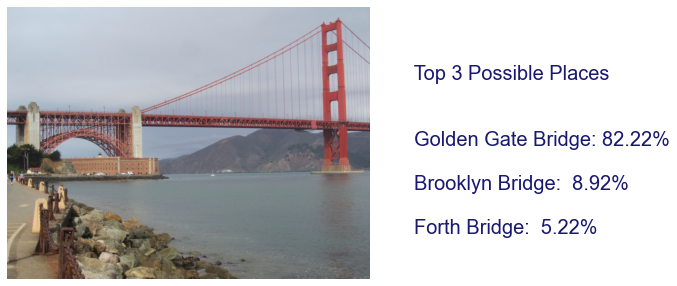

In [93]:
def suggest_locations(img_path):
    # get landmark predictions
    probs, landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image = Image.open(img_path)
    fig = plt.figure(figsize=(10,5))
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')
    txt = f"""
    Top 3 Possible Places 
    
    
    {landmarks[0][3:].replace('_', ' ')}: {probs[0]*100:5.2f}%
    
    {landmarks[1][3:].replace('_', ' ')}: {probs[1]*100:5.2f}%
    
    {landmarks[2][3:].replace('_', ' ')}: {probs[2]*100:5.2f}%"""
    plt.text(850, 500, txt, fontsize=20, color='midnightblue')

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ It performed better than I expected. 

1. Increase the training data either by collecting more instances and/or data augmentation
2. Adjust hyperparameters such as the the learning rate, maybe include more fully connected layers to the model at the end, to accelerate learning. Let it train further till it starts overfitting.
2. Try simpler algorithms to speed up the prediction process, to help a possible deployment in an app. This could be applied for a tourism app, or even it could be expanded to include some history of the place the algorithm predicts. 

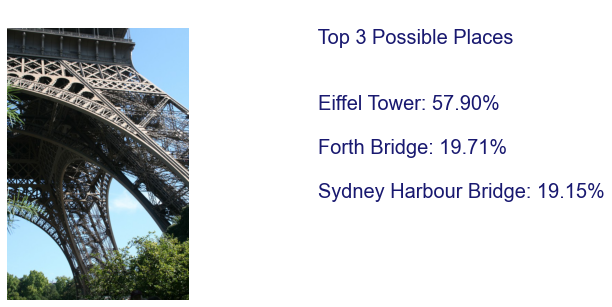

In [95]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('images/test/16.Eiffel_Tower/1.jpg')

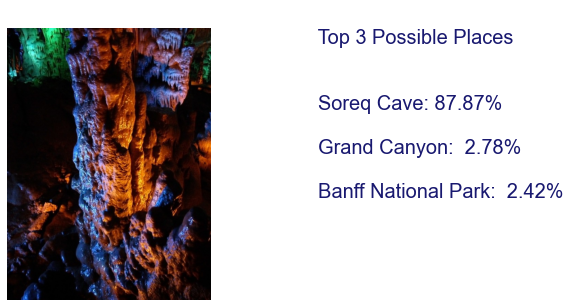

In [96]:
suggest_locations('images/test/24.Soreq_Cave/1.jpg')

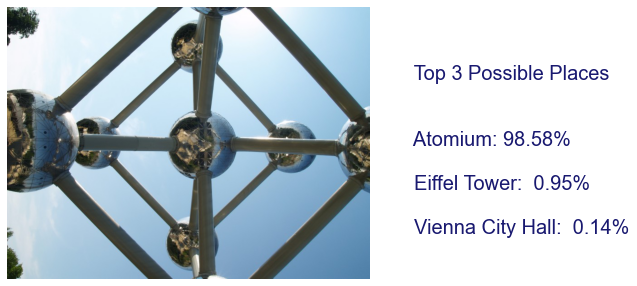

In [97]:
suggest_locations('images/test/37.Atomium/1.jpg')

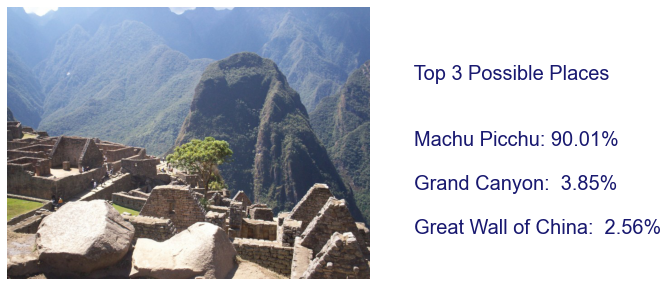

In [98]:
suggest_locations('images/test/41.Machu_Picchu/1.jpg')